Задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime, timedelta
import json
import re
import numpy as np

### Выгрузка постов

In [6]:
vk_token = 'token'

In [7]:
# получить json-ответ от API VK
def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response

In [8]:
# проверяем формат выдачи результата
test_url = 'https://api.vk.com/method/wall.get?access_token=' + vk_token + '&owner_id=-66669811&count=1&v=5.92'
test_response = getjson(test_url)
test_response

{'response': {'count': 3879,
  'items': [{'id': 215343,
    'from_id': -66669811,
    'owner_id': -66669811,
    'date': 1635762751,
    'marked_as_ads': 0,
    'post_type': 'post',
    'text': 'Нет, это не шутка! Попробовать 34 курса и интенсива Skillbox совершенно бесплатно 🤩\n\nНа целую неделю мы даем вам свободный доступ к нашим лекциям. Вы сможете попробовать себя в роли флориста, изучить основы Python, приглядеться к профессии PR-менеджера — в общем, познакомиться с кухней той специальности, которая интересна именно вам. \n\nВыбирайте свой курс и записывайтесь по ссылке: https://vk.cc/c0pI0X.',
    'is_pinned': 1,
    'attachments': [{'type': 'photo',
      'photo': {'album_id': -7,
       'date': 1635762751,
       'id': 457533900,
       'owner_id': -66669811,
       'has_tags': False,
       'access_key': '19ae8f760dbe8d3dec',
       'sizes': [{'height': 130,
         'url': 'https://sun4-12.userapi.com/impg/eHES6kiHbodfg69JxxnHhZ0fNRoaL48k8y0XuQ/bwL12IhYewY.jpg?size=104x130&q

In [9]:
# всего постов в группе
number_of_post = test_response['response']['count']
number_of_post

3879

In [10]:
# выгружаем последние 100 записей со стены
url = 'https://api.vk.com/method/wall.get?access_token=' + vk_token + '&owner_id=-66669811&count=100&v=5.92'
response = getjson(url)
df_100 = pd.json_normalize(response['response']['items'])

In [11]:
# выгружаем все записи
offset = 100
df_all = df_100

while df_all.shape[0] < number_of_post:
    payload = {'access_token': vk_token,
     'owner_id': -66669811,
     'count': 100,
     'offset': offset,
     'v': '5.92'}
    response_all = requests.get('https://api.vk.com/method/wall.get', params=payload)
    response_all = response_all.json()
    df_temp = pd.json_normalize(response_all['response']['items'])
    df_all = df_all.append(df_temp, ignore_index=True)
    offset += 100

In [12]:
# проверка, первый пост: "Чтобы куда-то расти, развивать себя..."
df_all.tail(1)['text'].values

array(['#internetmarketing #business #skillbox\n\nЧтобы куда-то расти, развивать себя и свой бизнес – нужно много читать и всегда быть в тренде, отслеживать появление новых инструментов, изучать кейсы и модные фишки.\n\nМы собрали для тебя самые важные и интересные ресурсы в сфере интернет-маркетинга, чтобы тебе не пришлось сёрфить интернет в поисках чего-то эдакого.\n\nЗабирай себе на стену, чтобы не потерять!'],
      dtype=object)

### Подготовка данных

In [13]:
# преобразование timestamp в datetime
df_all['date_time'] = df_all['date']\
    .apply(lambda x: (datetime.fromtimestamp(x) - timedelta(hours=0)))    
df_all.index = df_all['date_time']

# определение двухчасовых интервалов, к которым относятся посты
start_time = [f'0{x}:00:00' for x in range(0, 10, 2)] + [f'{x}:00:00' for x in range(10, 24, 2)]
finish_time = [f'0{x}:59:59' for x in range(1, 10, 2)] + [f'{x}:59:59' for x in range(11, 24, 2)]
df_all['day_time'] = 0

for i in range(len(start_time)):
    temp_index = df_all.between_time(start_time[i], finish_time[i]).index
    df_all.loc[temp_index, 'day_time'] = f'{start_time[i]} - {finish_time[i]}'

In [14]:
# выделяем текст сообщения из репостов
df_all.loc[df_all['copy_history'].notnull(), ['text']] = \
        df_all.loc[df_all['copy_history'].notnull()]['copy_history'].explode().apply(lambda x: x.get('text'))

# ставим маркеры на посты, заявляющие какую-либо рубрику
df_all['rubric_flag'] = df_all['text']\
                    .str.lower()\
                    .str.count(pat=r'\b[Р,р]убрик.\b')

# ставим маркеры на посты, заявляющие какой-либо опрос
df_all['poll'] = df_all['text']\
                    .str.lower()\
                    .str.count(pat=r'\b[О,о]прос.\b')

# выделяем теги из постов
df_all['tag'] = df_all['text'].str.lower().str.findall(pat=r'\B#\S+')
df_all['tag_0'] = df_all['tag'].apply(lambda x: sorted(x)).str.join(',')

In [15]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3879 entries, 2021-11-01 17:32:31 to 2016-04-01 15:38:31
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        3879 non-null   int64         
 1   from_id                   3879 non-null   int64         
 2   owner_id                  3879 non-null   int64         
 3   date                      3879 non-null   int64         
 4   marked_as_ads             3879 non-null   int64         
 5   post_type                 3879 non-null   object        
 6   text                      3879 non-null   object        
 7   is_pinned                 1 non-null      float64       
 8   attachments               3812 non-null   object        
 9   is_favorite               3879 non-null   bool          
 10  hash                      3879 non-null   object        
 11  post_source.type          3879 non-null   obje

Видим, что есть посты без указания количества просмотров, views.count = null в 515 постах.  

In [16]:
print(df_all[df_all['views.count'].isnull()]['date_time'].min())
print(df_all[df_all['views.count'].isnull()]['date_time'].max())
print(df_all[df_all['views.count'].notnull()]['date_time'].min())

2016-04-01 15:38:31
2016-12-29 01:04:50
2017-01-12 22:55:59


Следовательно, доступный счетчик просмотров в постах появляется с 2017 года.  
Для анализа выберем все посты, начиная с 2017 года - чтобы можно было использовать все заявленные в объектах "запись на стене" счетчики.

In [17]:
df_work = df_all.drop(index=df_all[df_all.index.year < 2017].index)

Определить, к какой рубрике относится тот или иной пост, можем двумя способами:  
1. Прочитать и определить самостоятельно. Но на большом количестве постов это не решение.
2. Ориентироваться на наличие указателей в постах: слова "рубрика", соответствующих тегов и названий рубрик в тексте. Используем этот способ. 

Всего есть $2^3$ вариантов комбинации этих трех параметров:  

| № п/п | "Рубрика" | Тег | Имя рубрики | 
| -: | :-: | :-: | :-: |
|  1  |  1  |  1  |  1  |
|  2  |  1  |  1  |  0  |
|  3  |  1  |  0  |  1  |
|  4  |  1  |  0  |  0  |
|  5  |  0  |  1  |  1  |
|  6  |  0  |  1  |  0  |
|  7  |  0  |  0  |  1  |
|  8  |  0  |  0  |  0  |

№ 8 нерабочий, остальные рассмотрим.

In [18]:
# выбираем теги, которыми отмечены сообщения с заявленными рубриками:
tag_list = df_work[df_work['rubric_flag'] == 1]['tag_0'].unique()
tag_list

array(['#skillbox_мультимедиа', '#skillbox_дизайн,#дайджестskillbox',
       '#skillbox_маркетинг', '#skillbox_программирование,#учим_html',
       '#skillbox_программирование,#в_закладки_skillbox',
       '#hr_совет_skillbox',
       '#skillbox_программирование,#сленг_программиста_sillbox',
       '#skillbox_программирование,#проще_говоря_skillbox',
       '#skillbox_программирование,#разработчики_шутят',
       '#skillbox_дизайн,#разбор_кейса_skillbox',
       '#answer@skillbox_education', '#designbattle@skillbox_education',
       '#friday_typeface@skillbox_education',
       '#wordoftheday@skillbox_education', '#weekbook@skillbox_education',
       '#question@skillbox_education', '',
       '#collections@skillbox_education', '#quiz@skillbox_education'],
      dtype=object)

Нужно выяснить, какие рубрики идут без тегов (значение ' ' в списке тегов):

In [19]:
for ind in df_work[(df_work['rubric_flag'] == 1) & (df_work['tag_0'] == '')].index:
    print(ind, '\n', df_work.loc[ind, 'text'], '\n\n')

2018-11-02 23:30:02 
 Новый месяц — новая рубрика, на этот раз — «Домашние работы». Название отражает всю суть: теперь мы каждую неделю будем делиться с вами успехами наших студентов.

К примеру, сегодня мы хотим вам показать работу Kirilla Kelly, выполненную в рамках первого модуля курса «Веб-дизайнер PRO». Перед ним стояла задача сделать редизайн корпоративного веб-сайта компании «Астерос». Как вам? ;)

Курс, который научит вас подобному, и все подробности по обучению здесь: https://vk.cc/8EstIN 


2018-04-26 14:21:55 
 Ребята, в прошлый раз вы активно задавали вопросы, так что мы решили ввести новую рубрику «Вопрос-ответ от Skillbox». 

В чем суть? Вы задаете вопросы — мы отвечаем. Вопросы любые: про Skillbox, дизайн, разработку, котиков, историю Российской Федерации, какая тактика на Короля Лича. Ответим на любой вопрос максимально подробно. 

Самое крутое — вы тоже можете отвечать, если знаете ответ на какой-то вопрос! Общаемся, знакомимся, обрастаем связями и друзьями! 




In [20]:
# добавляем теги на два поста вручную
df_work.loc['2018-11-02 23:30:02', 'tag_0'] = '#homeworks'
df_work.loc['2018-04-26 14:21:55', 'tag_0'] = '#answer@skillbox_education'

# обновляем tag_list
tag_list = df_work[df_work['rubric_flag'] == 1]['tag_0'].unique()

# выбираем сообщения, отмеченные тегами рубрик, для 'rubric_flag' меняем значение 0 на 1:
flag_list = df_work[(df_work['tag_0'].isin(tag_list)) & (df_work['rubric_flag'] == 0)].index
df_work.loc[flag_list, 'rubric_flag'] = 1

Выделяем вероятные названия рубрик:

In [21]:
# словарь-счетчик значений в «»
counter_dict = df_work['text'].str.findall(pat=r'«[\w, \s]+»').explode()\
                .value_counts().to_dict()

def namer(temp_list):
    '''Выделение одного варианта в «»: самый частый в массиве или единственный'''
    if len(temp_list) == 0:
        return
    elif len(temp_list) == 1:
        return temp_list[0]
    else:
        temp_dict = dict.fromkeys(temp_list)
        for quotes in temp_list:
            temp_dict[quotes] = counter_dict.get(quotes)
        return max(temp_dict, key=temp_dict.get) 

df_work['rubric_name'] = df_work['text'].str.findall(pat=r'«[\w, \s]+»').apply(namer)

Теперь у нас есть 3 указателя на рубрики, к которым относятся те или иные посты: `'rubric_flag'`, `'tag_0'`,  `'rubric_name'`, несколько несогласованные. С ними и будем работать.  
Нужно "стабилизировать" `'rubric_name'`: возможно, какие-то значения неверные, а каких-то недостает.

In [22]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_work[df_work['rubric_flag'] != 0].groupby(['tag_0', 'rubric_name'], dropna=False)['text'].count())

tag_0                                                   rubric_name                                
#answer@skillbox_education                              NaN                                            44
#collections@skillbox_education                         «ВКонтакте»                                     1
                                                        «Как проходить собеседование»                   1
                                                        «Миллионеры из App Store»                       1
                                                        «Онтико»                                        1
                                                        «Сбербанк»                                      2
                                                        «Сибирикс»                                      1
                                                        «Читать»                                        1
                                                    

Видим, что можно соотнести теги и рубрики определенным образом.  

Также нужно найти посты рубрики из условия - игра по управлению.

In [23]:
df_work[df_work['text'].str.findall(pat=r'[И, и]гр. по управлени.').explode().notnull()]['tag_0'].unique()

array(['#skillbox_управление,#игра_skillbox_по_управлению,#рабочая_ситуация_skillbox',
       '#skillbохуправление,#играskillbохпоуправлению,#рабочаяситуацияskillbox'],
      dtype=object)

In [24]:
rubric_name_dict = {
    '#answer@skillbox_education': '«Вопрос-ответ от Skillbox»'
    , '#collections@skillbox_education': '«Подборки»'
    , '#designbattle@skillbox_education': '«Дизайн-битва»'
    , '#friday_typeface@skillbox_education': '«Шрифт недели от Skillbox»'
    , '#hr_совет_skillbox': '«HR совет»'
    , '#question@skillbox_education': '«Вопрос от подписчика»'
    , '#quiz@skillbox_education': '«Опрос»'
    , '#skillbox_дизайн,#дайджестskillbox': '«Дайджест»'
    , '#skillbox_маркетинг': '«Маркетинг»'
    , '#skillbox_мультимедиа': '«Мультимедиа»'
    , '#skillbox_дизайн,#разбор_кейса_skillbox': '«Разбор кейса»'
    , '#skillbox_программирование,#в_закладки_skillbox': '«Программирование»'
    , '#weekbook@skillbox_education': '«Книга недели от Skillbox и МИФ»'
    , '#wordoftheday@skillbox_education': '«Слово дня»'
    , '#skillbox_дизайн,#разбор_кейса_skillbox': '«Разбор кейса_дизайн»'
    , '#skillbox_программирование,#разработчики_шутят': '«Разработчики шутят»'
    , '#skillbox_программирование,#сленг_программиста_sillbox': '«Сленг программиста»'
    , '#skillbox_программирование,#учим_html': '«Учим HTML»'
    , '#skillbox_управление,#игра_skillbox_по_управлению,#рабочая_ситуация_skillbox': '«Игра по управлению»'
    , '#skillbохуправление,#играskillbохпоуправлению,#рабочаяситуацияskillbox': '«Игра по управлению»'
}

Теперь проверяем те посты, в которых `'rubric_flag'` = 0 и есть теги и/или `'rubric_name'`. Всего таких постов:

In [25]:
df_work[(df_work['rubric_flag'] == 0) & ((df_work['tag_0'] != '') | (df_work['rubric_name'].notnull()))].shape[0]

2538

Количество уникальных тегов в них:

In [26]:
df_work[(df_work['rubric_flag'] == 0) & ((df_work['tag_0'] != '') | (df_work['rubric_name']\
                                                                     .notnull()))]['tag_0'].nunique()

392

Уникальных `'rubric_name'`:

In [27]:
df_work[(df_work['rubric_flag'] == 0) & ((df_work['tag_0'] != '') | (df_work['rubric_name']\
                                                                     .notnull()))]['rubric_name'].nunique()

580

И тех, и других много. Посмотрим, можно ли по тегам в них выделить явные рубрики или сгруппировать посты.  

Pаметно выделяются #статья_skillbox и группа #skillbox_дизайн, #skillbox_маркетинг, #skillbox_программирование, #skillbox_управление.   

Еще видим '#design_battle_skillbox,#skillbox_дизайн', уже размеченный выше (с другим тегом) как «Дизайн-битва», и '#skillbox_дизайн,#шрифты_skillbox', также размеченный выше с другим тегом как «Шрифт недели от Skillbox».

Также можно выделить 2 большие группы:    
- «Расписание» (содержат теги #расписание_skillbox,#skillbox_анонс,#вебинар_skillbox,#лекторий_skillbox)
- «Обучение» с тегами типа ..@skillbox_education - среди всех остальных.  

Будем рассматрирать только выявленные рубрики и группы постов.

In [28]:
df_work[df_work['rubric_flag'] == 0]\
            .groupby(['tag_0', 'rubric_name'], dropna=False)['text'].count()\
            .sort_values(ascending=False).head(60)

tag_0                                                                         rubric_name                  
                                                                              NaN                              476
#расписание_skillbox                                                          NaN                              112
#code@skillbox_education,#read@skillbox_education                             NaN                               95
#marketing@skillbox_education                                                 NaN                               85
#skillbox_маркетинг,#статья_skillbox                                          NaN                               85
#skillbox_дизайн,#статья_skillbox                                             NaN                               80
#design@skillbox_education,#read@skillbox_education                           NaN                               79
#design@skillbox_education                                                    NaN      

In [29]:
update_dict = {'#skillbox_дизайн': '«Дизайн»',
              '#skillbox_программирование': '«Программирование»',
              '#skillbox_управление': '«Управление»',
              '#design_battle_skillbox,#skillbox_дизайн': '«Дизайн-битва»',
              '#skillbox_дизайн,#шрифты_skillbox': '«Шрифт недели от Skillbox»'}

rubric_name_dict.update(update_dict)

for tag, name in rubric_name_dict.items():
    df_work.loc[df_work['tag_0'] == tag, 'rubric_name'] = name
    df_work.loc[df_work['tag_0'] == tag, 'rubric_flag'] = 1

contains_name_dict = {
    '#статья_skillbox': '«Статья»',
    '#расписание_skillbox': '«Расписание»',
    '#skillbox_анонс': '«Расписание»',
    '#вебинар_skillbox': '«Расписание»',
    '#лекторий_skillbox': '«Расписание»',
    '@skillbox_education': '«Обучение»'
}

for tag, name in contains_name_dict.items():
    df_work.loc[(df_work['rubric_flag'] == 0) & df_work['tag_0'].str.contains(pat=tag), 'rubric_name'] = name
    df_work.loc[(df_work['rubric_flag'] == 0) & df_work['tag_0'].str.contains(pat=tag), 'rubric_flag'] = 1
    
name_set = set(rubric_name_dict.values()).union(set(contains_name_dict.values()))

### Анализ показателей вовлеченности по времени публикации

Вовлеченность показывает реакцию аудитории на контент. Вовлеченность по публикации или аккаунту в целом считают по формуле:  

$$\frac{Реакции}{Подписчики}*100\%$$  
Будем использовать формулу для расчета вовлеченности по аккаунту в целом.  

Для расчета вовлеченности по отдельным постам немного изменим ее, в связи с тем, что статистикой появления подписчиков в группе мы не располагаем. Логично предположить, что количество подписчиков возрастает с течением времени, и их количество на более ранних постах меньше количества на более поздних.  
Поэтому для отдельных постов будем рассматривать два модифицированных показателя:

$$\frac{Лайки+Репосты}{Просмотры}*100\% = Показатель\ положительной\ реакции$$ 

$$\frac{Комментарии}{Просмотры}*100\% = Показатель\ интереса\ к\ посту$$

In [30]:
# общая вовлеченность; число подписчиков в группе 398220
gen_involv = (df_all['comments.count'].sum() + df_all['likes.count'].sum() + df_all['reposts.count'].sum()) /\
                398220 * 100
gen_involv

79.60901009492241

In [31]:
df_work.loc[:, 'positive_response'] = ((df_work.loc[:, 'likes.count'] + df_work.loc[:, 'reposts.count']) \
                                / df_work.loc[:, 'views.count']) * 100
df_work.loc[:, 'interest_level'] = (df_work.loc[:, 'comments.count'] / df_work.loc[:, 'views.count']) * 100

In [32]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3364 entries, 2021-11-01 17:32:31 to 2017-01-12 22:55:59
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        3364 non-null   int64         
 1   from_id                   3364 non-null   int64         
 2   owner_id                  3364 non-null   int64         
 3   date                      3364 non-null   int64         
 4   marked_as_ads             3364 non-null   int64         
 5   post_type                 3364 non-null   object        
 6   text                      3364 non-null   object        
 7   is_pinned                 1 non-null      float64       
 8   attachments               3310 non-null   object        
 9   is_favorite               3364 non-null   bool          
 10  hash                      3364 non-null   object        
 11  post_source.type          3364 non-null   obje

Посмотрим, как изменяются просмотры и показатели вовлеченности в зависимости от времени публикации: времени суток, дня недели, месяца.

**По времени суток:**

In [33]:
time_data = df_work.groupby('day_time')[['text', 'views.count', 'positive_response', 'interest_level']]\
                .agg({'text': 'count', 'views.count': ['sum', 'max', 'min', 'mean', 'median']
                      , 'positive_response': ['max', 'min', 'mean', 'median']
                      , 'interest_level': ['max', 'min', 'mean', 'median']})
time_data

text views.count                                   \
                    count         sum        max     min          mean   
day_time                                                                 
00:00:00 - 01:59:59   235   2664468.0    69459.0  2845.0  11338.161702   
02:00:00 - 03:59:59    12    127499.0    30306.0  2974.0  10624.916667   
12:00:00 - 13:59:59    12    150014.0    25943.0  5482.0  12501.166667   
14:00:00 - 15:59:59   504   8969385.0  1075476.0  2452.0  17796.398810   
16:00:00 - 17:59:59   544  10411072.0   165694.0  2681.0  19138.000000   
18:00:00 - 19:59:59   716  10915667.0   145407.0  2387.0  15245.344972   
20:00:00 - 21:59:59   603  10755930.0  1744089.0  2409.0  17837.363184   
22:00:00 - 23:59:59   738  10744070.0    82715.0  2506.0  14558.360434   

                             positive_response                                \
                      median               max       min      mean    median   
day_time                                                                       
00:00:00 - 01:59:59   7930.0          3.491174  0.038685  0.447679  0.368386   
02:00:00 - 03:59:59   8213.5          1.480036  0.201748  0.447230  0.323787   
12:00:00 - 13:59:59   9133.0          0.622986  0.191105  0.398824  0.413923   
14:00:00 - 15:59:59  10439.0          3.541582  0.032823  0.505665  0.407619   
16:00:00 - 17:59:59  17292.0         12.086362  0.050774  0.544704  0.444048   
18:00:00 - 19:59:59   9615.0          7.912317  0.000000  0.576358  0.487800   
20:00:00 - 21:59:59  10284.0          2.738511  0.041347  0.566990  0.460894   
22:00:00 - 23:59:59  12130.0          5.680534  0.041581  0.515726  0.427130   

                    interest_level                           
                               max  min      mean    median  
day_time                                                     
00:00:00 - 01:59:59       0.553107  0.0  0.041498  0.015567  
02:00:00 - 03:59:59       0.143249  0.0  0.024802  0.009648  
12:00:00 - 13:59:59       0.401313  0.0  0.076291  0.032329  
14:00:00 - 15:59:59       1.575037  0.0  0.108233  0.021850  
16:00:00 - 17:59:59       0.998782  0.0  0.052921  0.023769  
18:00:00 - 19:59:59       0.577488  0.0  0.036418  0.012116  
20:00:00 - 21:59:59       0.843926  0.0  0.035208  0.006905  
22:00:00 - 23:59:59       1.459854  0.0  0.043139  0.015413

Наиболее "читаемое" время - с 16:00 до 17:59, далее, со значительным отрывом, - 22:00-23:59, и потом почти рядом 20:00-21:59 и 14:00-15:59.  
Наименьшее медианное количество просмотров у постов, опубликованных с 00:00 до 01:59.  

Наибольший уровень позитивной реакции на посты, опубликованные в промежутки 18:00-19:59, 20:00-21:59 и 16:00-17:59. Наименьший - с 02:00 до 03:59.  

Наибольший уровень интереса отмечается к постам, опубликованным с 12:00 до 13:59, наименьший - с 20:00 до 21:59.

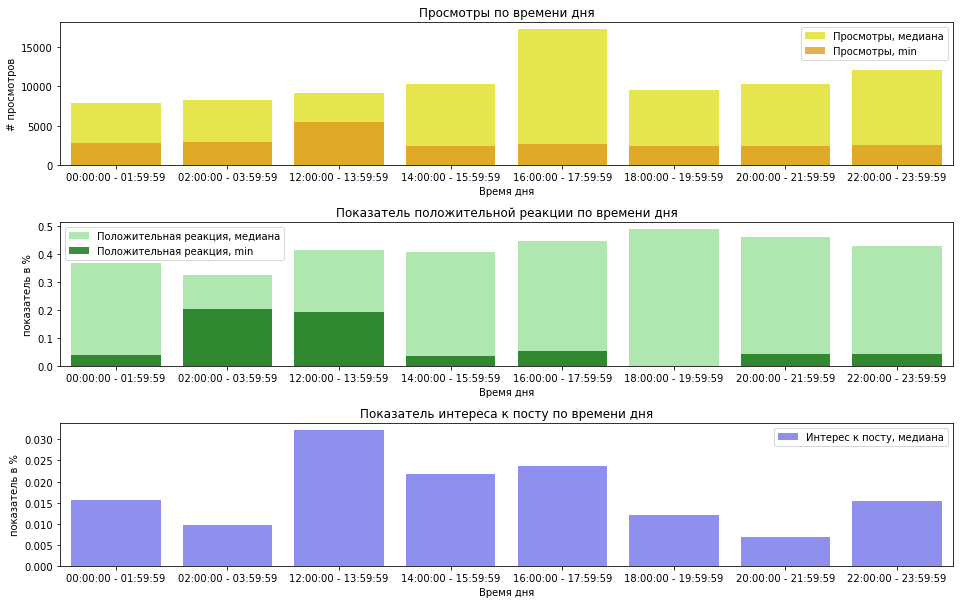

In [66]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(16, 10))
plt.subplots_adjust(hspace=0.4)

sns.barplot(x=time_data.index, y=time_data['views.count']['median']
            , color='yellow', alpha=0.8, ax=axs[0]
            , label='Просмотры, медиана')
sns.barplot(x=time_data.index, y=time_data['views.count']['min']
            , color='orange', alpha=0.8, ax=axs[0]
            , label='Просмотры, min')
axs[0].set_xlabel('Время дня')
axs[0].set_ylabel('# просмотров')   
axs[0].set_title('Просмотры по времени дня')
axs[0].legend()
sns.barplot(x=time_data.index, y=time_data['positive_response']['median']
            , color='lightgreen', alpha=0.8, ax=axs[1]
            , label='Положительная реакция, медиана')
sns.barplot(x=time_data.index, y=time_data['positive_response']['min']
            , color='green', alpha=0.8, ax=axs[1]
            , label='Положительная реакция, min')
axs[1].set_xlabel('Время дня')
axs[1].set_ylabel('показатель в %')
axs[1].set_title('Показатель положительной реакции по времени дня')
axs[1].legend()
sns.barplot(x=time_data.index, y=time_data['interest_level']['median']
            , color='blue', alpha=0.5, ax=axs[2]
            , label='Интерес к посту, медиана')
axs[2].set_xlabel('Время дня')
axs[2].set_ylabel('показатель в %')    
axs[2].set_title('Показатель интереса к посту по времени дня')
axs[2].legend()

plt.show()

**По дням недели**

In [67]:
day_data = df_work.groupby(df_work['date_time'].dt.day_name(locale='Russian'))\
                [['text', 'views.count', 'positive_response', 'interest_level']]\
                .agg({'text': 'count', 'views.count': ['sum', 'max', 'min', 'mean', 'median']
                      , 'positive_response': ['max', 'min', 'mean', 'median']
                      , 'interest_level': ['max', 'min', 'mean', 'median']})\
                .reindex(['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'])
day_data

text views.count                                            \
            count         sum        max     min          mean   median   
date_time                                                                 
Понедельник   572   8608942.0    95820.0  3028.0  15050.597902  11326.0   
Вторник       559   7756150.0   165688.0  2409.0  13875.044723   9813.0   
Среда         546  10003195.0  1744089.0  2387.0  18320.869963  10732.5   
Четверг       547   9376162.0  1075472.0  2506.0  17141.063985  10146.0   
Пятница       558   8246776.0    85410.0  2864.0  14779.168459   9724.0   
Суббота       324   5345874.0    67681.0  3355.0  16499.611111  12099.0   
Воскресенье   257   5363330.0   122820.0  3238.0  20868.988327  15823.0   

            positive_response                               interest_level  \
                          max       min      mean    median            max   
date_time                                                                    
Понедельник          2.139442  0.051840  0.488150  0.412841       1.575037   
Вторник              3.379868  0.038685  0.487569  0.388651       0.631313   
Среда                6.306306  0.000000  0.517905  0.410645       0.843997   
Четверг              3.542994  0.032823  0.506825  0.417707       1.369522   
Пятница             12.086362  0.067367  0.630112  0.485940       1.459854   
Суббота              2.947796  0.066991  0.526720  0.454861       0.474524   
Воскресенье          2.210025  0.060251  0.648394  0.576444       0.409659   

                                      
             min      mean    median  
date_time                             
Понедельник  0.0  0.052297  0.018517  
Вторник      0.0  0.048514  0.014071  
Среда        0.0  0.042153  0.013397  
Четверг      0.0  0.085272  0.012346  
Пятница      0.0  0.040952  0.011440  
Суббота      0.0  0.037289  0.012589  
Воскресенье  0.0  0.045623  0.027083

Лидер по просмотру постов - воскресенье, после идут суббота и понедельник.  

Наибольший медианный показатель позитивной реакции наблюдается в воскресенье, после идут пятница и суббота.  

Наибольший медианный показатель уровня интереса - в воскресенье, после идут понедельник и вторник.

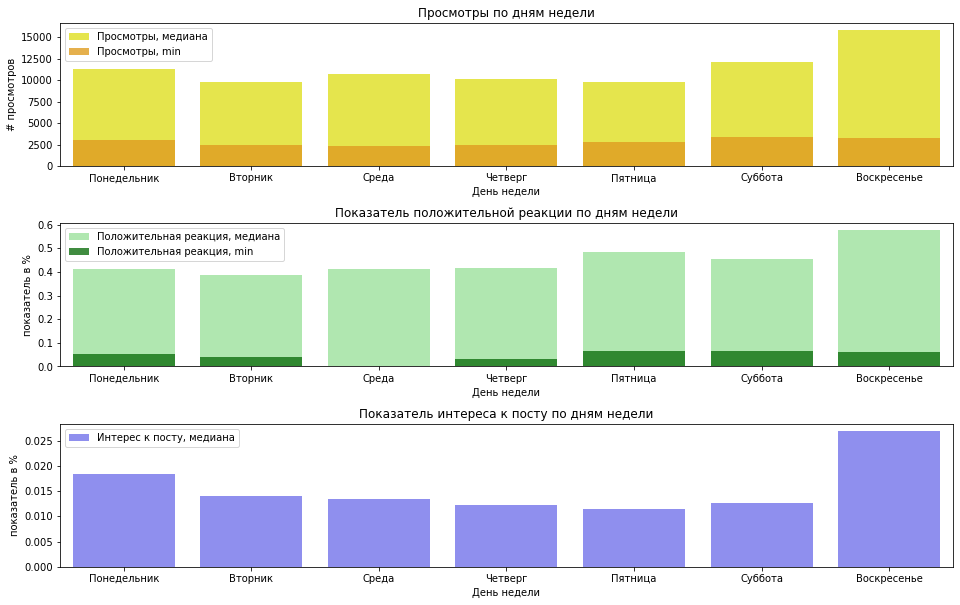

In [68]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(16, 10))
plt.subplots_adjust(hspace=0.4)

sns.barplot(x=day_data.index, y=day_data['views.count']['median']
            , color='yellow', alpha=0.8, ax=axs[0]
            , label='Просмотры, медиана')
sns.barplot(x=day_data.index, y=day_data['views.count']['min']
            , color='orange', alpha=0.8, ax=axs[0]
            , label='Просмотры, min')
axs[0].set_xlabel('День недели')
axs[0].set_ylabel('# просмотров')   
axs[0].set_title('Просмотры по дням недели')
axs[0].legend()
sns.barplot(x=day_data.index, y=day_data['positive_response']['median']
            , color='lightgreen', alpha=0.8, ax=axs[1]
            , label='Положительная реакция, медиана')
sns.barplot(x=day_data.index, y=day_data['positive_response']['min']
            , color='green', alpha=0.8, ax=axs[1]
            , label='Положительная реакция, min')
axs[1].set_xlabel('День недели')
axs[1].set_ylabel('показатель в %')
axs[1].set_title('Показатель положительной реакции по дням недели')
axs[1].legend()
sns.barplot(x=day_data.index, y=day_data['interest_level']['median']
            , color='blue', alpha=0.5, ax=axs[2]
            , label='Интерес к посту, медиана')
axs[2].set_xlabel('День недели')
axs[2].set_ylabel('показатель в %')    
axs[2].set_title('Показатель интереса к посту по дням недели')
axs[2].legend()

plt.show()

**По месяцам**

In [69]:
monthes = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь'
           , 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
month_data = df_work.groupby(df_work['date_time'].dt.month_name(locale='Russian'))\
                [['text', 'views.count', 'positive_response', 'interest_level']]\
                .agg({'text': 'count', 'views.count': ['sum', 'max', 'min', 'mean', 'median']
                      , 'positive_response': ['max', 'min', 'mean', 'median']
                      , 'interest_level': ['max', 'min', 'mean', 'median']})\
                .reindex(monthes)
month_data

text views.count                                            \
          count         sum        max     min          mean   median   
date_time                                                               
Январь      197   3394282.0    68101.0  5452.0  17229.857868  13708.0   
Февраль     250   3717806.0    63408.0  2387.0  14871.224000  10713.5   
Март        304   4301244.0    79870.0  2409.0  14148.828947  10657.0   
Апрель      332   4647950.0    83599.0  2611.0  13999.849398   9827.5   
Май         287   6541431.0  1744089.0  3166.0  22792.442509  11362.0   
Июнь        276   5140947.0   145407.0  4457.0  18626.619565  15193.5   
Июль        313   5378761.0   125244.0  4909.0  17184.539936  11971.0   
Август      315   5355777.0  1075472.0  3899.0  17002.466667   9621.0   
Сентябрь    265   4034927.0   165688.0  5452.0  15226.139623  10862.0   
Октябрь     307   4445433.0    73264.0  4380.0  14480.237785   9534.0   
Ноябрь      252   3220293.0   122820.0  3073.0  12778.940476   8755.5   
Декабрь     265   4521578.0    52708.0  5133.0  17062.558491  12704.0   

          positive_response                               interest_level       \
                        max       min      mean    median            max  min   
date_time                                                                       
Январь            12.086362  0.103296  0.565707  0.450721       0.984048  0.0   
Февраль            7.912317  0.000000  0.576245  0.446229       0.653376  0.0   
Март               2.210025  0.053095  0.544329  0.451940       0.505717  0.0   
Апрель             2.169667  0.073502  0.579675  0.494007       1.575037  0.0   
Май                2.024637  0.053525  0.538446  0.458747       1.369522  0.0   
Июнь               1.550253  0.068261  0.456748  0.372634       1.136364  0.0   
Июль               2.049879  0.041347  0.456470  0.376364       1.018585  0.0   
Август             2.310063  0.032823  0.532844  0.460044       1.141366  0.0   
Сентябрь           3.044081  0.041581  0.559780  0.444290       0.843193  0.0   
Октябрь            5.871924  0.082283  0.624667  0.438548       0.638978  0.0   
Ноябрь             3.379868  0.038685  0.505089  0.386605       0.746674  0.0   
Декабрь            1.941422  0.096855  0.485026  0.410765       0.665212  0.0   

                               
               mean    median  
date_time                      
Январь     0.045513  0.014071  
Февраль    0.039616  0.012177  
Март       0.031987  0.007684  
Апрель     0.068711  0.014441  
Май        0.063102  0.022472  
Июнь       0.070416  0.017574  
Июль       0.048022  0.013173  
Август     0.040088  0.009594  
Сентябрь   0.049245  0.014502  
Октябрь    0.052109  0.019775  
Ноябрь     0.055525  0.019449  
Декабрь    0.051703  0.022289

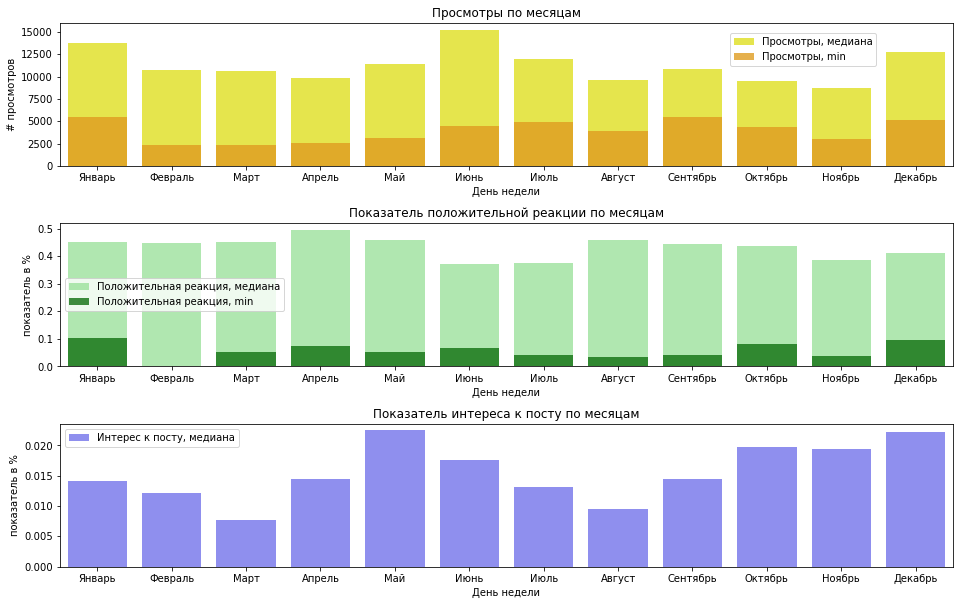

In [70]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(16, 10))
plt.subplots_adjust(hspace=0.4)

sns.barplot(x=month_data.index, y=month_data['views.count']['median']
            , color='yellow', alpha=0.8, ax=axs[0]
            , label='Просмотры, медиана')
sns.barplot(x=month_data.index, y=month_data['views.count']['min']
            , color='orange', alpha=0.8, ax=axs[0]
            , label='Просмотры, min')
axs[0].set_xlabel('День недели')
axs[0].set_ylabel('# просмотров')   
axs[0].set_title('Просмотры по месяцам')
axs[0].legend(loc=(0.75, 0.7))
sns.barplot(x=month_data.index, y=month_data['positive_response']['median']
            , color='lightgreen', alpha=0.8, ax=axs[1]
            , label='Положительная реакция, медиана')
sns.barplot(x=month_data.index, y=month_data['positive_response']['min']
            , color='green', alpha=0.8, ax=axs[1]
            , label='Положительная реакция, min')
axs[1].set_xlabel('День недели')
axs[1].set_ylabel('показатель в %')
axs[1].set_title('Показатель положительной реакции по месяцам')
axs[1].legend(loc='center left')
sns.barplot(x=month_data.index, y=month_data['interest_level']['median']
            , color='blue', alpha=0.5, ax=axs[2]
            , label='Интерес к посту, медиана')
axs[2].set_xlabel('День недели')
axs[2].set_ylabel('показатель в %')    
axs[2].set_title('Показатель интереса к посту по месяцам')
axs[2].legend()

plt.show()

### Показатели вовлеченности в зависимости от рубрики

In [72]:
rubric_data = df_work[df_work['rubric_name'].isin(name_set)]\
                .groupby('rubric_name')[['text', 'views.count', 'positive_response', 'interest_level']]\
                .agg({'text': 'count', 'views.count': ['sum', 'max', 'min', 'mean', 'median']
                      , 'positive_response': ['max', 'min', 'mean', 'median']
                      , 'interest_level': ['max', 'min', 'mean', 'median']})
rubric_data

text views.count                      \
                                 count         sum        max      min   
rubric_name                                                              
«HR совет»                           3     47511.0    20177.0  12564.0   
«Вопрос от подписчика»              14     96617.0     8682.0   4579.0   
«Вопрос-ответ от Skillbox»          44    352563.0    13078.0   3817.0   
«Дайджест»                           1     12525.0    12525.0  12525.0   
«Дизайн-битва»                      49    495377.0    26124.0   4999.0   
«Дизайн»                            89   1895556.0    83599.0   8245.0   
«Игра по управлению»                18    165428.0    11748.0   7638.0   
«Книга недели от Skillbox и МИФ»    37    334104.0    14821.0   5052.0   
«Маркетинг»                         39    863668.0    41875.0  10109.0   
«Мультимедиа»                       17    294159.0    20434.0  12689.0   
«Обучение»                         902  11203879.0  1744089.0   2453.0   
«Опрос»                              2      6053.0     3330.0   2723.0   
«Подборки»                          71   1272735.0    79870.0   5757.0   
«Программирование»                  50   1283660.0    68101.0   9396.0   
«Разбор кейса_дизайн»                2     15234.0     7681.0   7553.0   
«Разработчики шутят»                 3     51842.0    20744.0  14749.0   
«Расписание»                       211   3916544.0    70542.0   5804.0   
«Сленг программиста»                 1     13973.0    13973.0  13973.0   
«Слово дня»                          5     50097.0    12496.0   8035.0   
«Статья»                           346   6114706.0    79262.0   6990.0   
«Управление»                        17    444510.0    67719.0  11024.0   
«Учим HTML»                          3     85418.0    33871.0  25429.0   
«Шрифт недели от Skillbox»          56    674122.0    67115.0   3893.0   

                                                        positive_response  \
                                          mean   median               max   
rubric_name                                                                 
«HR совет»                        15837.000000  14770.0          0.270614   
«Вопрос от подписчика»             6901.214286   6908.5          0.562667   
«Вопрос-ответ от Skillbox»         8012.795455   8260.0          0.291495   
«Дайджест»                        12525.000000  12525.0          0.255489   
«Дизайн-битва»                    10109.734694   8868.0          0.376569   
«Дизайн»                          21298.382022  17974.0          1.558620   
«Игра по управлению»               9190.444444   9106.5          0.342996   
«Книга недели от Skillbox и МИФ»   9029.837838   8997.0          0.782779   
«Маркетинг»                       22145.333333  21632.0          1.165373   
«Мультимедиа»                     17303.470588  17264.0          0.591063   
«Обучение»                        12421.151885   7192.5          2.210025   
«Опрос»                            3026.500000   3026.5          0.330518   
«Подборки»                        17925.845070  11177.0          1.705373   
«Программирование»                25673.200000  23327.0          1.265657   
«Разбор кейса_дизайн»              7617.000000   7617.0          0.312459   
«Разработчики шутят»              17280.666667  16349.0          0.255496   
«Расписание»                      18561.819905  18805.0          1.934133   
«Сленг программиста»              13973.000000  13973.0          0.243326   
«Слово дня»                       10019.400000   9345.0          0.726523   
«Статья»                          17672.560694  18455.0          2.161967   
«Управление»                      26147.647059  23649.0          1.176906   
«Учим HTML»                       28472.666667  26118.0          0.870952   
«Шрифт недели от Skillbox»        12037.892857   8465.5          2.043107   

                                                               interest_level  \
                         

In [76]:
rubric_data.describe()

text   views.count                                            \
            count           sum           max           min          mean   
count   23.000000  2.300000e+01  2.300000e+01     23.000000     23.000000   
mean    86.086957  1.290882e+06  1.096459e+05   8695.478261  14920.981020   
std    194.746202  2.600768e+06  3.573711e+05   5162.588787   6751.713426   
min      1.000000  6.053000e+03  3.330000e+03   2453.000000   3026.500000   
25%      3.000000  5.096950e+04  1.280150e+04   5025.500000   9604.922222   
50%     18.000000  3.341040e+05  2.074400e+04   7638.000000  13973.000000   
75%     53.000000  1.068202e+06  6.791000e+04  11774.500000  18243.832488   
max    902.000000  1.120388e+07  1.744089e+06  25429.000000  28472.666667   

                    positive_response                                   \
             median               max        min       mean     median   
count     23.000000         23.000000  23.000000  23.000000  23.000000   
mean   13643.673913          0.931918   0.161560   0.389202   0.345495   
std     6347.010477          0.692843   0.105680   0.178354   0.152102   
min     3026.500000          0.243326   0.041347   0.138832   0.137866   
25%     8666.750000          0.321489   0.078206   0.235695   0.231313   
50%    12525.000000          0.726523   0.115101   0.344715   0.296988   
75%    18214.500000          1.412138   0.239491   0.501608   0.441358   
max    26118.000000          2.210025   0.402022   0.773463   0.713605   

      interest_level                                   
                 max        min       mean     median  
count      23.000000  23.000000  23.000000  23.000000  
mean        0.321147   0.013742   0.075692   0.058686  
std         0.405182   0.050955   0.128073   0.113505  
min         0.000000   0.000000   0.000000   0.000000  
25%         0.076097   0.000000   0.022253   0.006369  
50%         0.181915   0.000000   0.035783   0.023146  
75%         0.302509   0.000000   0.070922   0.050081  
max         1.575037   0.243807   0.616630   0.533464

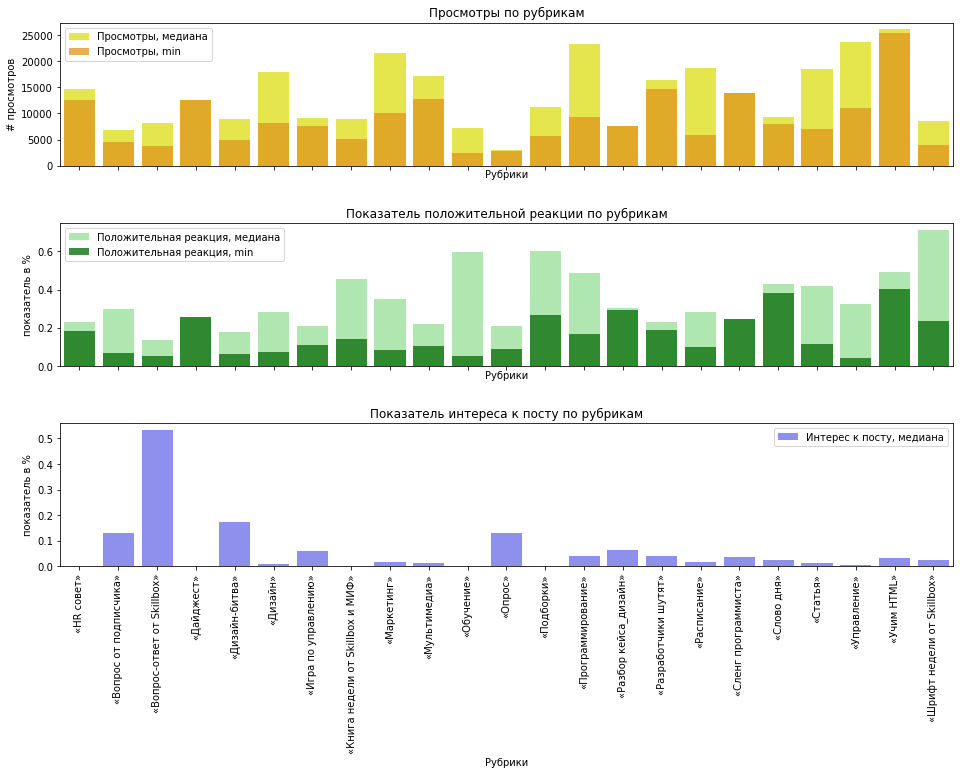

In [74]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(16, 10))
plt.subplots_adjust(hspace=0.4)

sns.barplot(x=rubric_data.index, y=rubric_data['views.count']['median']
            , color='yellow', alpha=0.8, ax=axs[0]
            , label='Просмотры, медиана')
sns.barplot(x=rubric_data.index, y=rubric_data['views.count']['min']
            , color='orange', alpha=0.8, ax=axs[0]
            , label='Просмотры, min')
axs[0].set_xlabel('Рубрики')
axs[0].set_ylabel('# просмотров')   
axs[0].set_title('Просмотры по рубрикам')
axs[0].legend()
sns.barplot(x=rubric_data.index, y=rubric_data['positive_response']['median']
            , color='lightgreen', alpha=0.8, ax=axs[1]
            , label='Положительная реакция, медиана')
sns.barplot(x=rubric_data.index, y=rubric_data['positive_response']['min']
            , color='green', alpha=0.8, ax=axs[1]
            , label='Положительная реакция, min')
axs[1].set_xlabel('Рубрики')
axs[1].set_ylabel('показатель в %')
axs[1].set_title('Показатель положительной реакции по рубрикам')
axs[1].legend()
sns.barplot(x=rubric_data.index, y=rubric_data['interest_level']['median']
            , color='blue', alpha=0.5, ax=axs[2]
            , label='Интерес к посту, медиана')
axs[2].set_xlabel('Рубрики')
axs[2].set_ylabel('показатель в %')    
axs[2].set_title('Показатель интереса к посту по рубрикам')
axs[2].legend()
axs[2].set_xticklabels(labels=rubric_data.index, rotation=90)

plt.show()

Наибольшее количество просмотров у рубрик «Учим HTML», «Управление» и «Программирование». Наименьшее - «Опрос», «Вопрос от подписчика», «Обучение».  

Максимальная положительная реакция: «Шрифт недели от Skillbox», «Подборки», «Обучение». Минимальная: «Вопрос-ответ от Skillbox», «Дизайн-битва», «Игра по управлению».  
    В целом показатель положительной реакции по рубрикам достаточно устойчивый, т. е. лайки и репосты в этих рубриках явление почти закономерное, а рубрики с максимальным их количеством говорят о ценности контента для подписчиков - его активно сохраняют / отмечают.

Максимальный уровень интереса: «Вопрос-ответ от Skillbox», «Дизайн-битва», «Вопрос от подписчика», «Опрос». Это рубртки, построенные на обратной связи / взаимодействии с подписчиками.  Минимальный: «HR совет», «Дайджест», «Книга недели от Skillbox и МИФ», «Обучение», «Подборки».

В значениях `'views.count'` максимум превышает третий квартиль на 2 порядка. Рассмотрим его отдельно:

In [83]:
df_work[df_work['views.count'] == df_work['views.count'].max()]

,id,from_id,owner_id,date,marked_as_ads,post_type,text,is_pinned,attachments,is_favorite,...,post_source.data,date_time,day_time,rubric_flag,poll,tag,tag_0,rubric_name,positive_response,interest_level
date_time,,,,,,,,,,,,,,,,,,,,,
2018-05-23 20:00:11,24338,-66669811,-66669811,1527080411,0,post,"Хей-хей, ребята. Мы тут с Лентачом запустили с...",NaN,"[{'type': 'link', 'link': {'url': 'http://skil...",False,...,NaN,2018-05-23 20:00:11,20:00:00 - 21:59:59,1,0,[#test@skillbox_education],#test@skillbox_education,«Обучение»,0.053724,0.000401


In [84]:
df_work[df_work['views.count'] == df_work['views.count'].max()]['text'].values

array(['Хей-хей, ребята. Мы тут с Лентачом запустили спецпроект, который поможет понять, кто вы в мире Digital. \n \nДа, это тест, но он сделан только из emoji, так что вероятность ошибки в нем — всего 1%! Врывайтесь — https://vk.cc/85VVQ8 — и делитесь результатами с друзьями и в комментариях!\n\n#test@skillbox_education'],
      dtype=object)

Тест из эмодзи по просмотрам "взлетел". При этом показатели positive_response и interest_level ближе к минимальным значениям.

Теперь просмотры по рубрикам в зависимости от времени публикации постов:

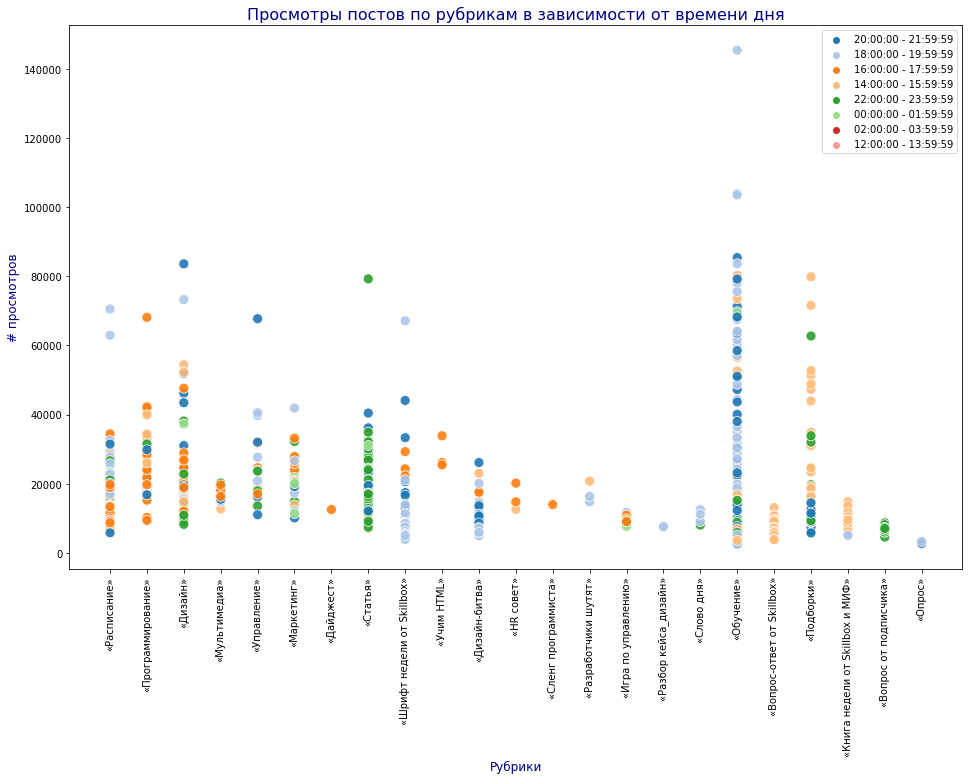

In [111]:
data = df_work[df_work['rubric_name'].isin(name_set)]\
                .drop(df_work[df_work['views.count'] == df_work['views.count'].max()].index)

fig, axs = plt.subplots(figsize=(16, 10))

sns.scatterplot(x='rubric_name', y='views.count', data=data
                , hue='day_time', palette='tab20', s=100, alpha=0.9)
plt.xlabel('Рубрики', color='navy', fontsize=12)
plt.ylabel('# просмотров', color='navy', fontsize=12)   
plt.title('Просмотры постов по рубрикам в зависимости от времени дня', color='navy', fontsize=16)
plt.legend()
plt.xticks(rotation=90)

plt.show()

Время дня с максимальным числом просмотров в целом по массиву - 16:00-17:59. В это время публикации максимальное количество просмотров в рубриках «Программирование», «Учим HTML», «HR совет»; «Сленг программиста» и «Дайджест» формально тоже относятся к этой группе, но фактически в них по одному посту.  
Заметная часть рубрик наиболее читаема при публикациях в промежуток с 18:00 до 21:59.  
Для рубрик «Разработчики шутят», «Вопрос-ответ от Skillbox», «Подборки», «Книга недели от Skillbox и МИФ» это промежуток с 14:00 до 15:59.  
Ориентируясь на эти результаты, можно сказать, что удачное время публикации - это примерно с 16:00 до 23:00, т. е. не просто вторая половина дня, а вечернее время.

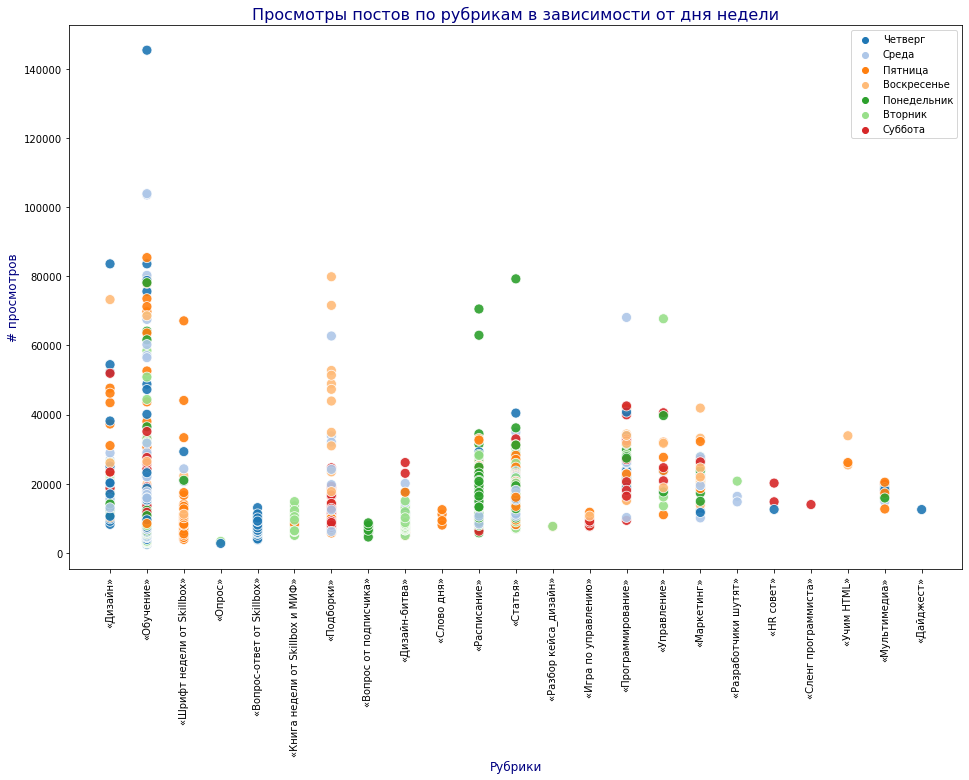

In [113]:
fig, axs = plt.subplots(figsize=(16, 10))

sns.scatterplot(x='rubric_name', y='views.count', data=data
                , hue=df_work['date_time'].dt.day_name(locale='Russian'), palette='tab20', s=100, alpha=0.9)
plt.xlabel('Рубрики', color='navy', fontsize=12)
plt.ylabel('# просмотров', color='navy', fontsize=12)   
plt.title('Просмотры постов по рубрикам в зависимости от дня недели', color='navy', fontsize=16)
plt.legend()
plt.xticks(rotation=90)

plt.show()

Зависимость между количеством просмотров и днем публикации постов по рубрикам отсутствует. Скорее, важно удобное для прочтения время появления поста в ленте. 